In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from pathlib import Path

In [2]:
# Constants
csv_path = Path("./test_rig_treadmill.csv")
TRANSDUCER_MV_PER_V = 1.5

# Design-derived Constants
DAC_MAX = 4095
DAC_PER_VOLT = DAC_MAX/3.3
DAC_MIDSCALE_V = 1.65 # V
TORQUE_FSR = TRANSDUCER_MV_PER_V # [V] with 10V excitation voltage and 100x amplification on the PCB.
x1 = (10, DAC_MIDSCALE_V + TORQUE_FSR, 4095)
x2 = (-10, DAC_MIDSCALE_V - TORQUE_FSR, 0)

m_torque_per_volt = (x2[0] - x1[0])/(x2[1] - x1[1]) # [oz.-in. per volt] slope.
m_torque_per_raw_adc = (x2[0] - x1[0])/(x2[2] - x1[2]) # [oz.-in. per dac value] slope.

In [3]:
# Read the data.
csv_data = np.genfromtxt(csv_path, delimiter=',').T
input_dac = csv_data[0]
measured_adc = csv_data[1]

In [4]:
x3 = (0, DAC_MIDSCALE_V, measured_adc[0]) # "no load" datapt. Note that the measured value is an average.

In [5]:
# Raw adc values to oz.-in.
adc_to_oz_in = lambda x: m_torque_per_raw_adc * (x - x3[2]) + x3[0]

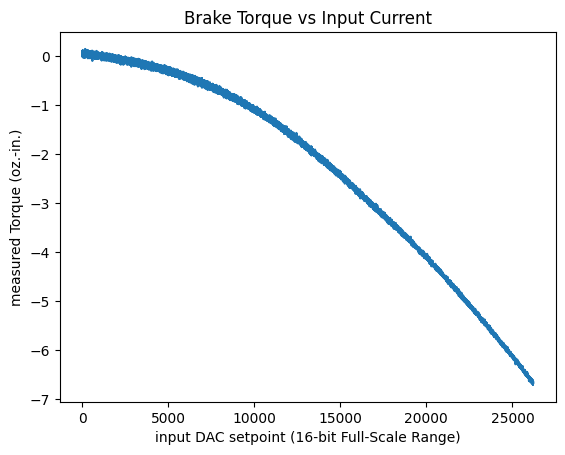

In [6]:
# Desired format: input torque to output raw DAC setting.
plt.title("Brake Torque vs Input Current")
plt.xlabel(f"input DAC setpoint (16-bit Full-Scale Range)")
plt.ylabel("measured Torque (oz.-in.)")
plt.plot(input_dac, np.vectorize(adc_to_oz_in)(measured_adc))
plt.show()

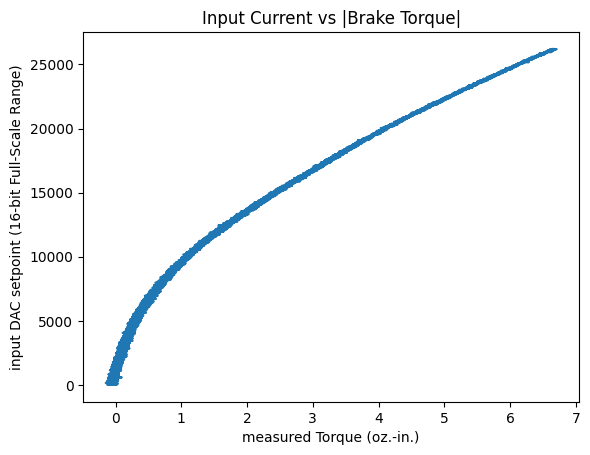

In [7]:
plt.title("Input Current vs |Brake Torque|")
plt.ylabel(f"input DAC setpoint (16-bit Full-Scale Range)")
plt.xlabel("measured Torque (oz.-in.)")
plt.plot(-np.vectorize(adc_to_oz_in)(measured_adc), input_dac)
plt.show()

In [163]:
def power_law_curve(x, a, k, b, c):#, c, d, e, f):
    #return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f
    return a * pow((x - c), k) + b

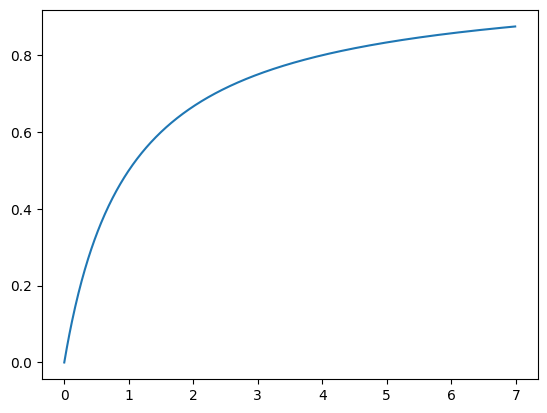

In [180]:
test_x = np.arange(0, 7, 0.01)
#test_y = power_law_curve(test_x, -0.1, 0.1, 0.1, 0.1, 0.1, 0)
test_y = power_law_curve(test_x, -1, -1, 1, -1)
plt.plot(test_x, test_y)
plt.show()

In [223]:
popt, pcov = curve_fit(power_law_curve, -np.vectorize(adc_to_oz_in)(measured_adc), input_dac, p0=(-1, -1, 1, -1),
                    bounds=((-np.inf, -np.inf, -np.inf, -10), (np.inf, np.inf, 10, np.inf)))

In [224]:
popt

array([ 1.19083818e+04,  4.69245631e-01, -3.41036280e+03, -1.56531673e-01])

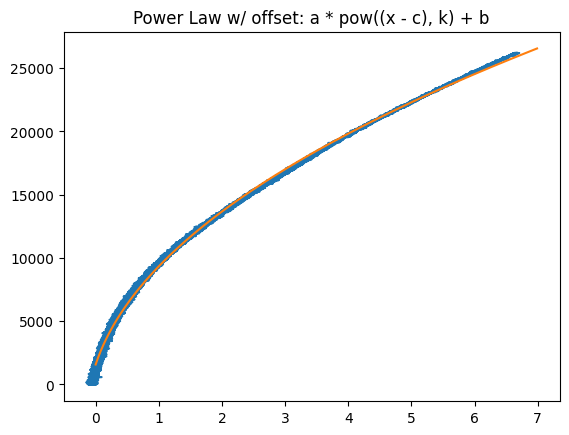

In [225]:
fit_y = power_law_curve(test_x, *popt)
plt.title("Power Law w/ offset: a * pow((x - c), k) + b")
plt.plot(-np.vectorize(adc_to_oz_in)(measured_adc), input_dac)
plt.plot(test_x, fit_y)
plt.show()